In this notebook, we will create a linear regression pipeline for the california housing dataset. We will train different models using this dataset and decide which model has the best predictive power. We aim to correctly guess the pricing of a house given multiple features.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV

california_housing = fetch_california_housing(as_frame=True)


Let's investigate our data first:

In [2]:
import pandas as pd
house = pd.DataFrame(california_housing.frame)
house

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
pd.DataFrame.corr(house) #check correlation between features

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


In this dataset, longitute and latitude are significantly negatively correlated. Average rooms and average begrooms are significantly positive correlated. THere are some other correlations as well. It is usually better to remove these features before fitting. Let us first fit with using all the features, and next using forward feature selection obtain the most compact model.

In [4]:
X = house[house.columns[:-1]].values; y = house[house.columns[-1]].values
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=123)

In [5]:
pipeline1 = Pipeline([
    ("s_scaler", StandardScaler()),
    ("lr_model", LinearRegression())
])

#define the grid
param_grid1 = {}

#fit the grid and print the score on the test set
grid = GridSearchCV(pipeline1, param_grid1, cv=10, n_jobs = 1)
grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print(grid.score(X_test, y_test))

Best params:  {}
0.6104546894797875


With using only linear regression, we can reach a score of 0.61. Next, let us include interactions between parameters using polynomial features.

In [6]:
pipeline2 = Pipeline([
    ('poly_feat', PolynomialFeatures()),
    ("s_scaler", StandardScaler()),
    ("lr_model", LinearRegression())
])


param_grid2 = {'poly_feat__degree': [2, 3],'poly_feat__interaction_only': [True,False]}


In [7]:
#fit the grid and print the score on the test set
grid2 = GridSearchCV(pipeline2, param_grid2, cv=10,n_jobs = 1)
grid2.fit(X_train, y_train)

print("Best params: ", grid2.best_params_)
print(grid2.score(X_test, y_test))

Best params:  {'poly_feat__degree': 2, 'poly_feat__interaction_only': True}
0.11165297307353905


It seems like we broke something, now let us investigate how we can improve the performance.

In [8]:
#define the pipeline
pipeline3 = Pipeline(steps=[('poly_feat', PolynomialFeatures()),  ("s_scaler", StandardScaler()),
                            ('lr_model', Ridge())])

#define the grid
param_grid3 = {'poly_feat__degree': [2,3],'poly_feat__interaction_only': [True,False], 
               'poly_feat__include_bias': [True,False], 'lr_model__alpha':[0.01,0.1,1,5,10,15,50,100]}


In [9]:
#fit the grid and print the score on the test set
grid3 = GridSearchCV(pipeline3, param_grid3, cv=10,n_jobs = 1)
grid3.fit(X_train, y_train)

print("Best params: ", grid3.best_params_)
print(grid3.score(X_test, y_test))

Best params:  {'lr_model__alpha': 10, 'poly_feat__degree': 2, 'poly_feat__include_bias': True, 'poly_feat__interaction_only': True}
0.0998855192722593


Note that, when we include all the interactions between features we have the curse of dimensionality with way too many features with not a lot of samples in our hands. Let us clear some of the features by fitting linear regression over and over on the subet of features, removing the least contributing feature at each step:

In [10]:
no_features = len(X_train[0])

max_validation_score = 100
current_range = np.arange(no_features)

while True: 
    validation_score = [] 
    for index in current_range:
        new_range = np.delete(current_range, np.where(current_range == index), axis=0)
        print('Selected_features:',new_range)
        grid.fit(X_train[:,new_range], y_train)
        score = grid.score(X_test[:,new_range], y_test)
        print('Test set score', score)
        validation_score.append(score)
        
    ### remove the feature with the least predictive impact on our model
    remove_feature = current_range[np.argmax(validation_score)]  
    
    max_validation_score = max(validation_score)
    if max_validation_score >= 0.6: ## if the prediction score is still high, we continue
        print("Remove feature "+ house.columns[remove_feature])
        current_range = np.delete(current_range, np.where(current_range == remove_feature), axis=0)
    else: break
print('Features remaining after applying forward feature selection:', house.columns[current_range])
    

Selected_features: [1 2 3 4 5 6 7]
Test set score 0.40231086349302747
Selected_features: [0 2 3 4 5 6 7]
Test set score 0.5998259470729352
Selected_features: [0 1 3 4 5 6 7]
Test set score 0.6059645297099411
Selected_features: [0 1 2 4 5 6 7]
Test set score 0.6014170690516063
Selected_features: [0 1 2 3 5 6 7]
Test set score 0.6105603495435721
Selected_features: [0 1 2 3 4 6 7]
Test set score 0.6098582995869997
Selected_features: [0 1 2 3 4 5 7]
Test set score 0.5388020667969831
Selected_features: [0 1 2 3 4 5 6]
Test set score 0.5377349868106414
Remove feature Population
Selected_features: [1 2 3 5 6 7]
Test set score 0.4024678448017286
Selected_features: [0 2 3 5 6 7]
Test set score 0.5992244749449637
Selected_features: [0 1 3 5 6 7]
Test set score 0.6060226943228715
Selected_features: [0 1 2 5 6 7]
Test set score 0.6015056120276894
Selected_features: [0 1 2 3 6 7]
Test set score 0.6100176647947171
Selected_features: [0 1 2 3 5 7]
Test set score 0.5379506618408817
Selected_features: 

In [11]:
feature_subset = ['MedInc', 'HouseAge', 'AveBedrms', 'Latitude', 'Longitude', 'MedHouseVal']
X_train_new = X_train[:,[0,1,2,6,7]]; X_test_new = X_test[:,[0,1,2,6,7]]

Our myopic heuristic claims these are the features we can use without losing significant predictive power. Interestingly, latitude and longitude both make it to the list although they have very high correlation. Sometimes we can keep these in, if we want to be extra careful though, maybe removing one or the other could be an option.

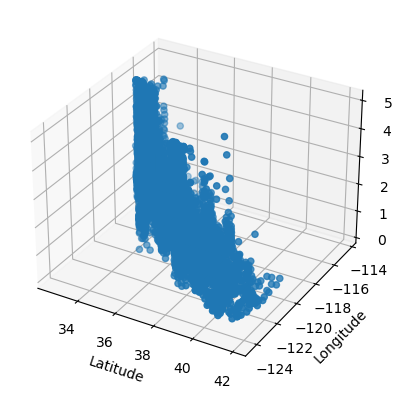

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.scatter(house.Latitude, house.Longitude, house.MedHouseVal)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('MedHouseVal')

plt.show()

In [13]:
grid.fit(X_train_new, y_train)
grid2.fit(X_train_new, y_train)
grid3.fit(X_train_new, y_train)
print('first_grid_scores', grid.score(X_test_new, y_test))
print('second_grid_scores',grid2.score(X_test_new, y_test))
print('third_grid_scores',grid3.score(X_test_new, y_test))

first_grid_scores 0.6010661504777268
second_grid_scores 0.653368467390962
third_grid_scores 0.6512060428827906


We see a very promising result here. By removing some of the features ourselves beforehand, we could get rid of the curse of dimensionality. 


I wanted to work with linear regression because now we can interpret the error distributions and feature importance checking our grid2 model more in-depth:

In [14]:
grid2.best_params_

{'poly_feat__degree': 3, 'poly_feat__interaction_only': False}

In [15]:
test_predictions = grid2.predict(X_test_new)
errors = test_predictions - y_test

Text(0, 0.5, 'Residual error')

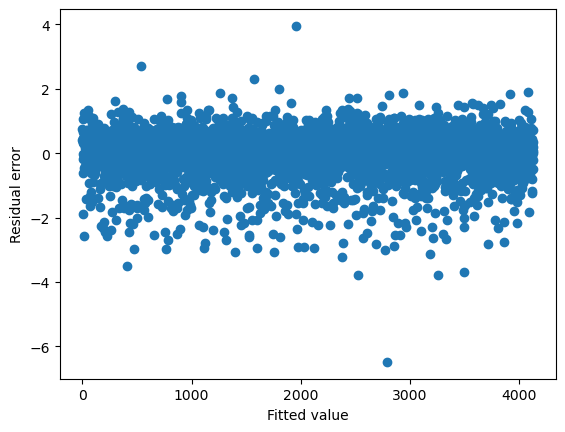

In [16]:
plt.scatter(np.arange(len(errors)),errors)
plt.xlabel('Fitted value')
plt.ylabel('Residual error')

Residual errors are seems to be distributed around 0 as we wanted. Only three points have high residual errors, other than those our fit seems to be strong.

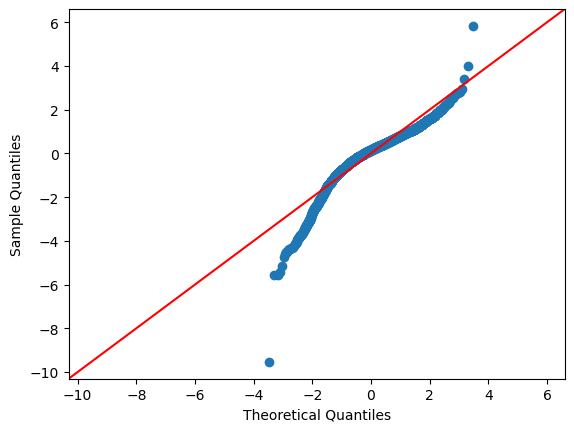

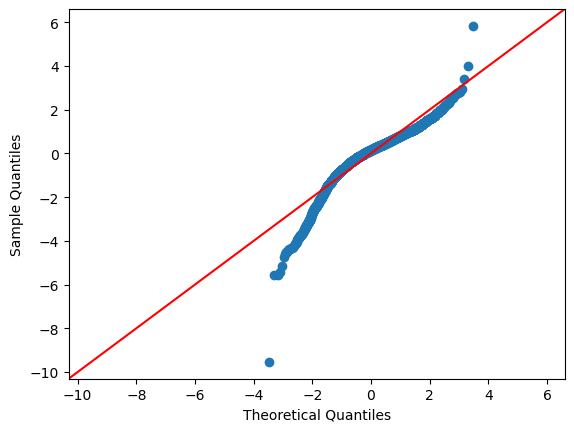

In [17]:
import statsmodels.api as sm
  
standardized_errors = (errors-np.mean(errors))/np.std(errors)
sm.qqplot(standardized_errors, line ='45')

Seems like our model still has issues with normal distribution. We can go and check our dependent variables again:


In [18]:
grid.fit(X_train_new, np.log(y_train))
grid2.fit(X_train_new, np.log(y_train))
grid3.fit(X_train_new, np.log(y_train))
print('first_grid_scores_transformed', grid.score(X_test_new, np.log(y_test+0.0001)))
print('second_grid_scores_transformed',grid2.score(X_test_new, np.log(y_test+0.0001)))
print('third_grid_scores_transformed',grid3.score(X_test_new, np.log(y_test+0.0001)))

first_grid_scores_transformed 0.6138210806754212
second_grid_scores_transformed 0.6700563762725449
third_grid_scores_transformed 0.6720409374292464


In [19]:
test_predictions_t = grid2.predict(X_test_new)
errors_t = test_predictions_t - np.log(y_test+0.0001)


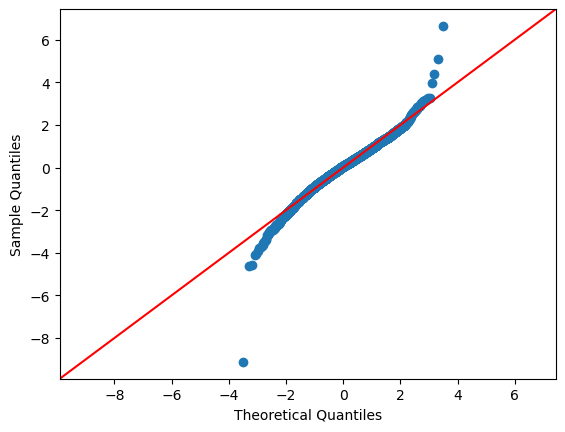

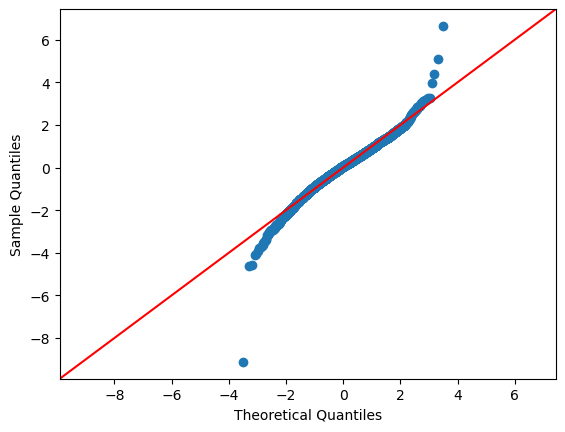

In [20]:
import statsmodels.api as sm
  
standardized_errors_t = (errors_t-np.mean(errors_t))/np.std(errors_t)
sm.qqplot(standardized_errors_t, line ='45')

Text(0, 0.5, 'Residual error')

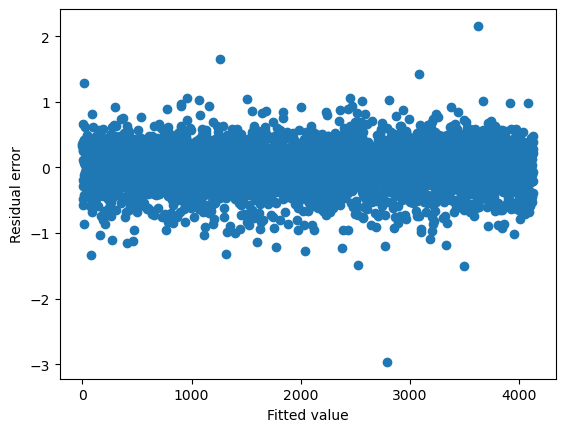

In [21]:
plt.scatter(np.arange(len(errors_t)),errors_t)
plt.xlabel('Fitted value')
plt.ylabel('Residual error')

Taking the logarithm of the y values might alleviate the problems we see in the graphs, here are the updated results. Inclusion of polynomial values still increase the predictive power of our model as seen in R2 values. Let us finish it with comparing the MAE results of two models, with and without transforming the dependent variables.

In [22]:
print('Before transformation MAE: ', np.mean(np.abs(test_predictions - y_test)))
print('After transformation MAE: ' , np.mean(np.abs(np.exp(test_predictions_t) - y_test)))

Before transformation MAE:  0.4762196214429156
After transformation MAE:  0.482205385688173


We can apply other metrics such as RMSE and MSE, however, from the MAE values maybe the transformation is not required since it increases the error between predicted values and test values of dependent variables.

Overall, adding polynomial features actually increase the predictive power of our model and we see an increase of 0.05 by including them. We sobserve that feature selection in a smart way as a preprocessing can increase the predictive power of our models.